In [1]:
from agents import *
from model import *
import numpy as np


In [2]:
models = [ElFarolBar(N=100, crowdthreshold=60, memory_size=m) for m in [5, 10, 20]]
for model in models:
    for i in range(400):
        model.step()


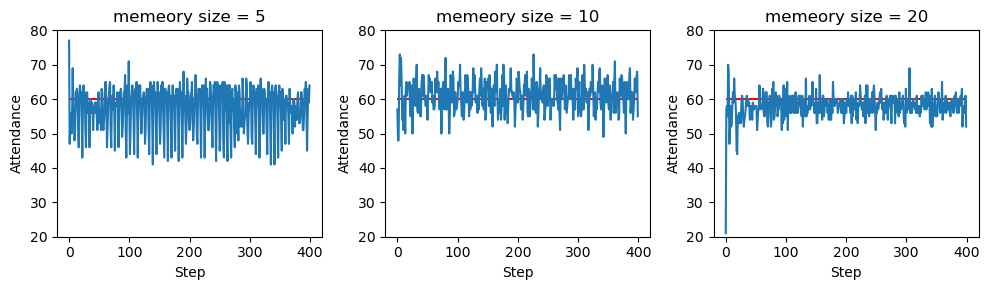

In [3]:
import matplotlib.pyplot as plt

n = 60
plt.figure(figsize=(10, 3))
ms = [5, 10, 20]
for idx in range(3):
    model = models[idx]
    plt.subplot(1, 3, idx + 1)
    df = model.datacollector.get_model_vars_dataframe()
    plt.plot(df["Customers"])
    plt.xlabel("Step")
    plt.ylabel("Attendance")
    plt.ylim([20, 80])
    plt.title("memory size = " + str(ms[idx]))
    plt.hlines(n, 0, 400, "r")
    plt.tight_layout()
plt.show()
# plt.savefig('memorysize.png',dpi = 300)


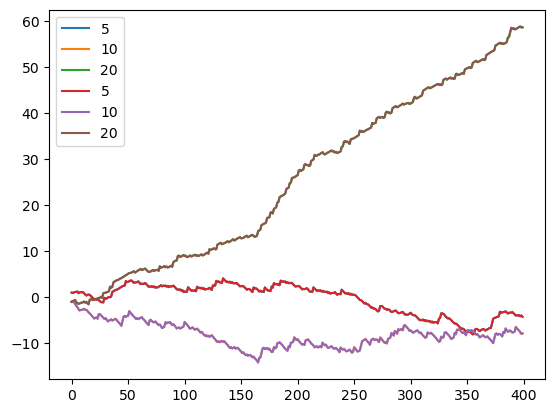

In [5]:
for idx in range(len(ms)):
    model = models[idx]
    df = model.datacollector.get_agent_vars_dataframe()
    plt.plot(df["Utility"].groupby("Step").mean(), label=str(ms[idx]))
plt.legend()
plt.show()


In [6]:
# decisions made on across trials
import seaborn as sns

plt.figure(figsize=(12, 4))
for idx in range(len(ms)):
    plt.subplot(1, 3, idx + 1)
    model = models[idx]
    df = model.datacollector.get_agent_vars_dataframe()
    df.reset_index(inplace=True)
    sns.heatmap(df.pivot(index="AgentID", columns="Step", values="Attendance"))
    plt.tight_layout()
    plt.title("Memory size = " + str(ms[idx]))
plt.legend()
plt.savefig("Memorysize.heatmap.png")


No handles with labels found to put in legend.


In [181]:
nss = [5, 10, 20]
n = 60
models = [ElFarolBar(N=100, crowdthreshold=n, num_strategies=ns) for ns in nss]
for model in models:
    for i in range(400):
        model.step()


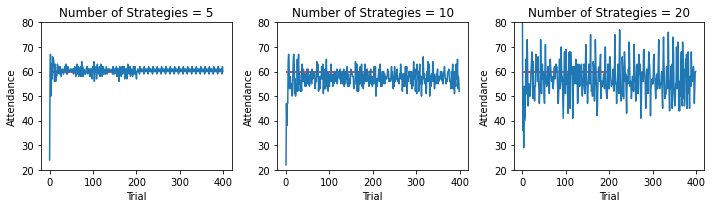

In [182]:
# attdance of the bar
plt.figure(figsize=(10, 3))

for idx in range(len(nss)):
    model = models[idx]
    plt.subplot(1, 3, idx + 1)
    df = model.datacollector.get_model_vars_dataframe()
    plt.plot(df["Customers"])
    plt.xlabel("Trial")
    plt.ylabel("Attendance")
    plt.ylim([20, 80])
    plt.title("Number of Strategies = " + str(nss[idx]))
    plt.hlines(n, 0, 200, "r")
    plt.tight_layout()
plt.savefig("builtin_model.png", dpi=300)


In [16]:
# Cognitive based model IBLT


In [7]:
n = 50
trials = 400
models = [
    ElFarolBarIBLT(N=100, crowdthreshold=n, decay={0.1: 1}),
    ElFarolBarIBLT(N=100, crowdthreshold=n, decay={1: 1}),
    ElFarolBarIBLT(N=100, crowdthreshold=n, decay={2.5: 1}),
    ElFarolBarIBLT(N=100, crowdthreshold=n, decay={5: 1}),
]

for model in models:
    for i in range(trials):
        model.step()


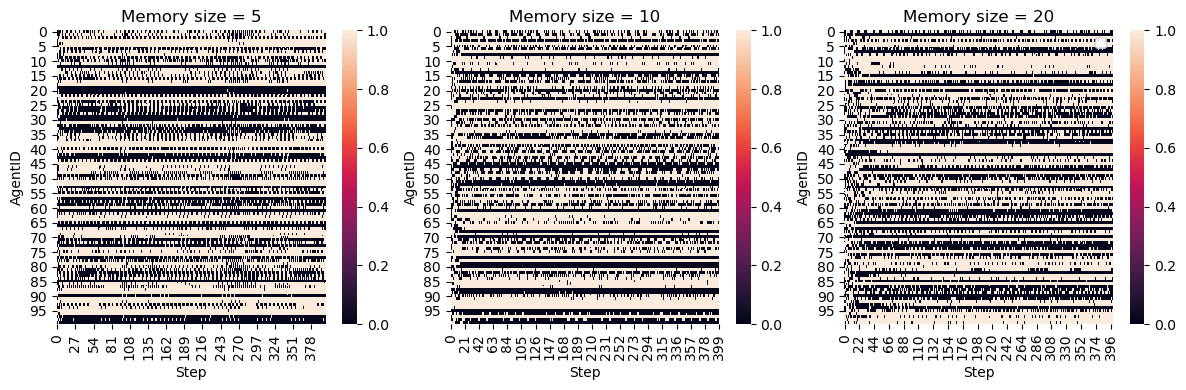

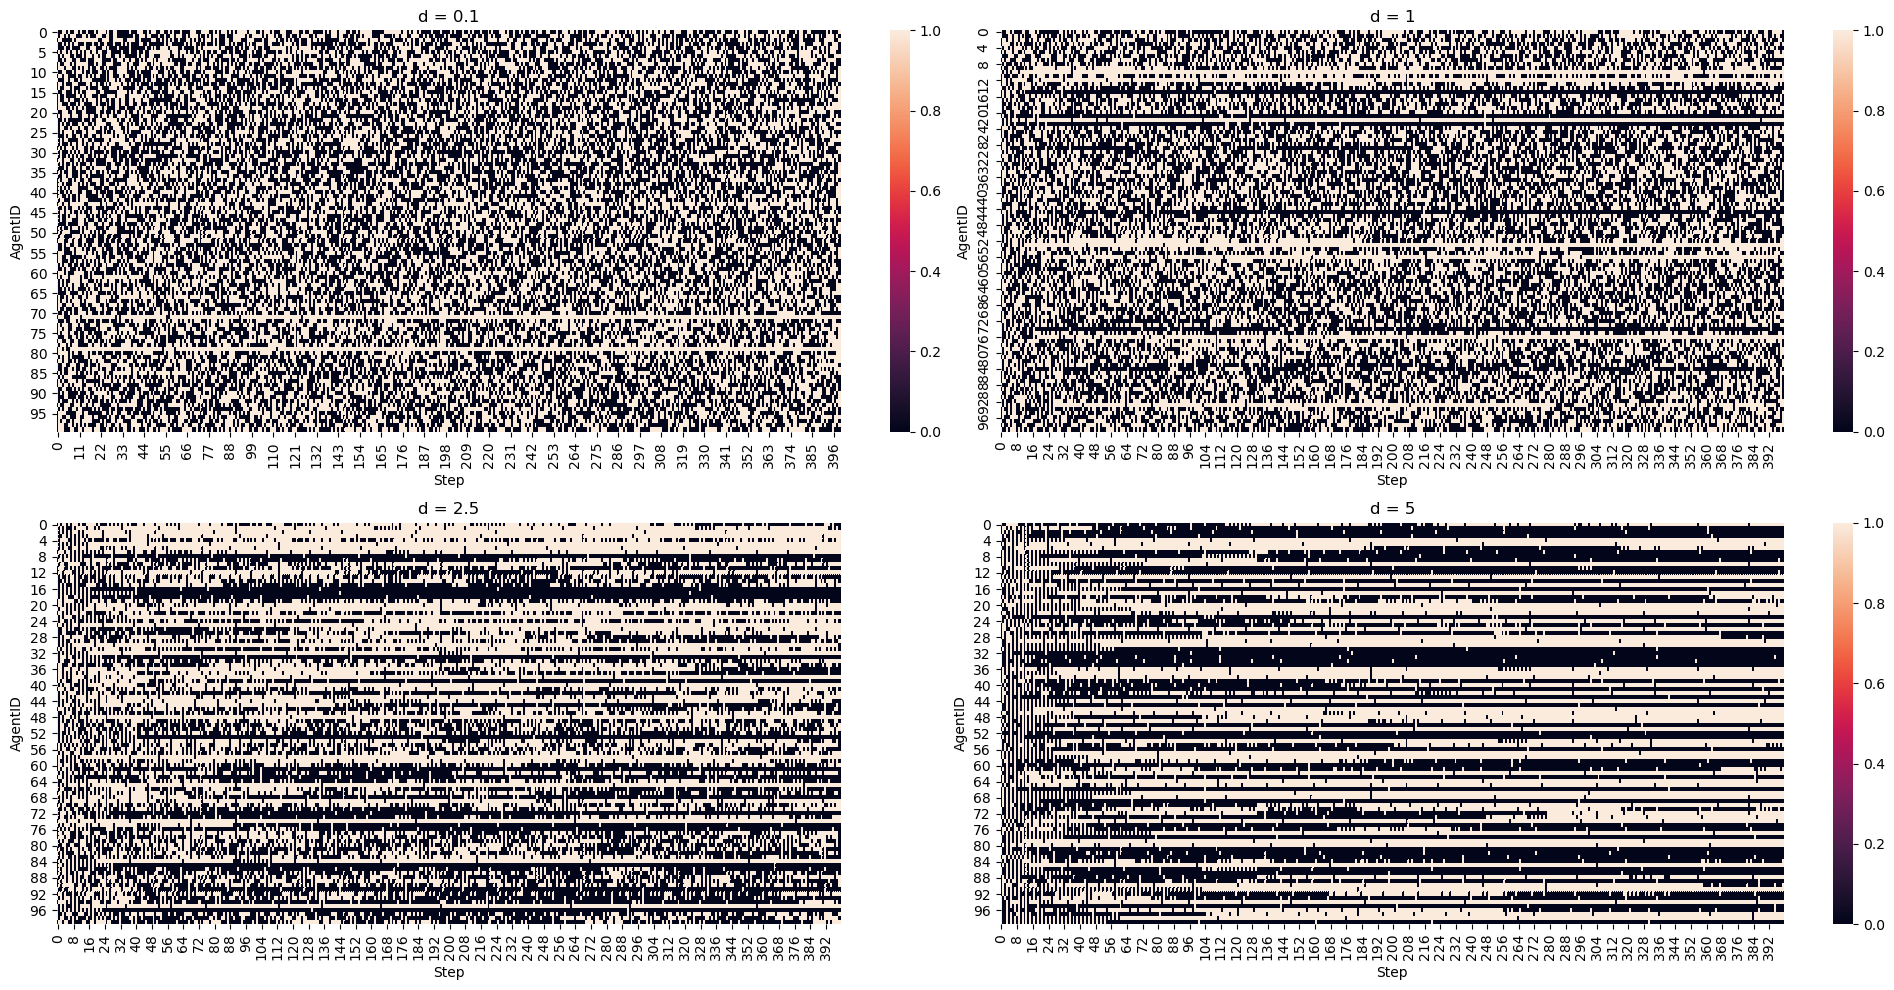

In [8]:
import seaborn as sns

d = [0.1, 1, 2.5, 5]
plt.figure(figsize=(20, 10))
for idx in range(4):
    plt.subplot(2, 2, idx + 1)
    model = models[idx]
    df = model.datacollector.get_agent_vars_dataframe()
    df.reset_index(inplace=True)
    sns.heatmap(df.pivot(index="AgentID", columns="Step", values="Attendance"))
    plt.tight_layout()
    plt.title("d = " + str(d[idx]))
plt.show()
# plt.savefig('attendance.homogeneous.png',dpi= 300)


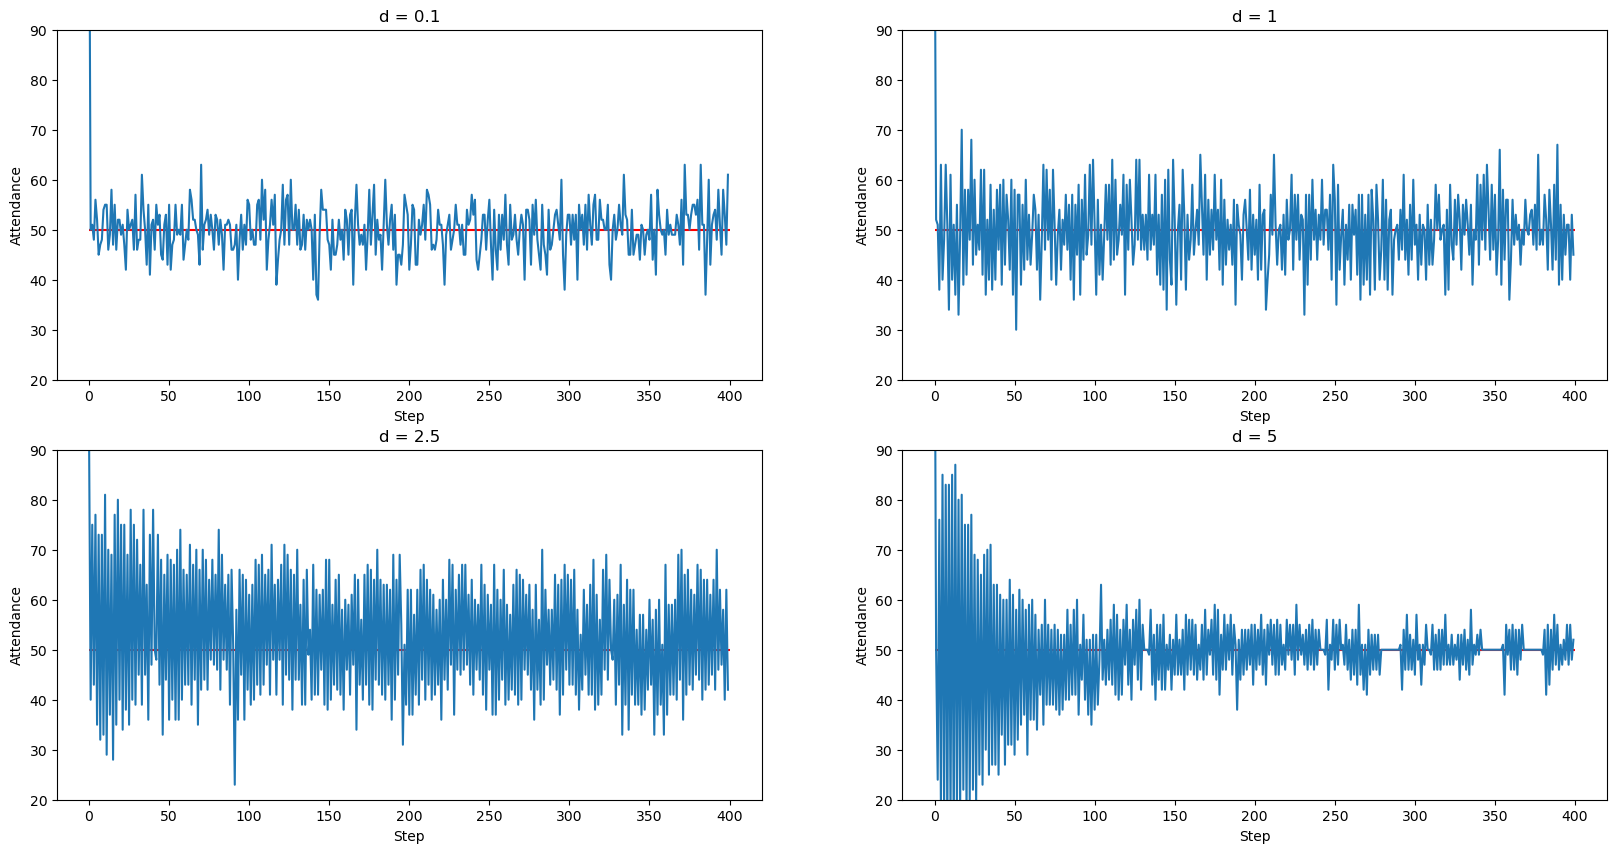

In [9]:
d = [0.1, 1, 2.5, 5]
plt.figure(figsize=(20, 10))
for idx in range(4):
    plt.subplot(2, 2, idx + 1)
    model = models[idx]
    df = model.datacollector.get_model_vars_dataframe()
    plt.plot(df["Customers"], label=str(d[idx]))
    plt.ylim([20, 90])
    plt.title("d = " + str(d[idx]))
    plt.hlines(n, 0, 400, "r")
    plt.xlabel("Step")
    plt.ylabel("Attendance")
plt.show()
# plt.savefig('cog_homogeneous.png',dpi = 300)


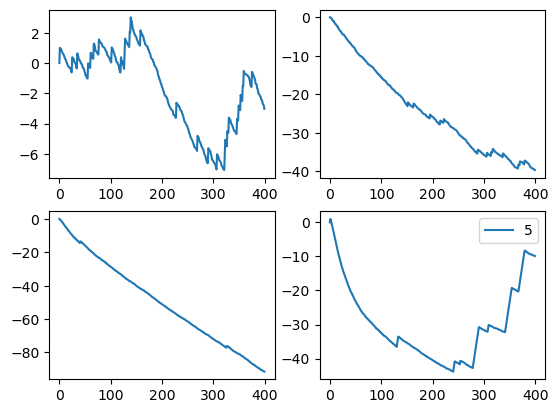

In [10]:
import matplotlib.pyplot as plt

d = [0.1, 1, 2.5, 5]
for idx in range(4):
    plt.subplot(2, 2, idx + 1)
    model = models[idx]
    df = model.datacollector.get_agent_vars_dataframe()
    plt.plot(df["Utility"].groupby("Step").mean(), label=str(d[idx]))
plt.legend()
plt.show()


In [11]:
n = 60
trials = 400
decays = {
    "90:10": {0.1: 0.9, 2.5: 0.1},
    "75:25": {0.1: 0.75, 2.5: 0.25},
    "50:50": {0.1: 0.5, 2.5: 0.5},
    "25:75": {0.1: 0.25, 2.5: 0.75},
    "10:90": {0.1: 0.1, 2.5: 0.9},
}
models = {
    name: ElFarolBarIBLT(N=100, crowdthreshold=n, decay=d) for name, d in decays.items()
}

for _, model in models.items():
    for i in range(trials):
        model.step()


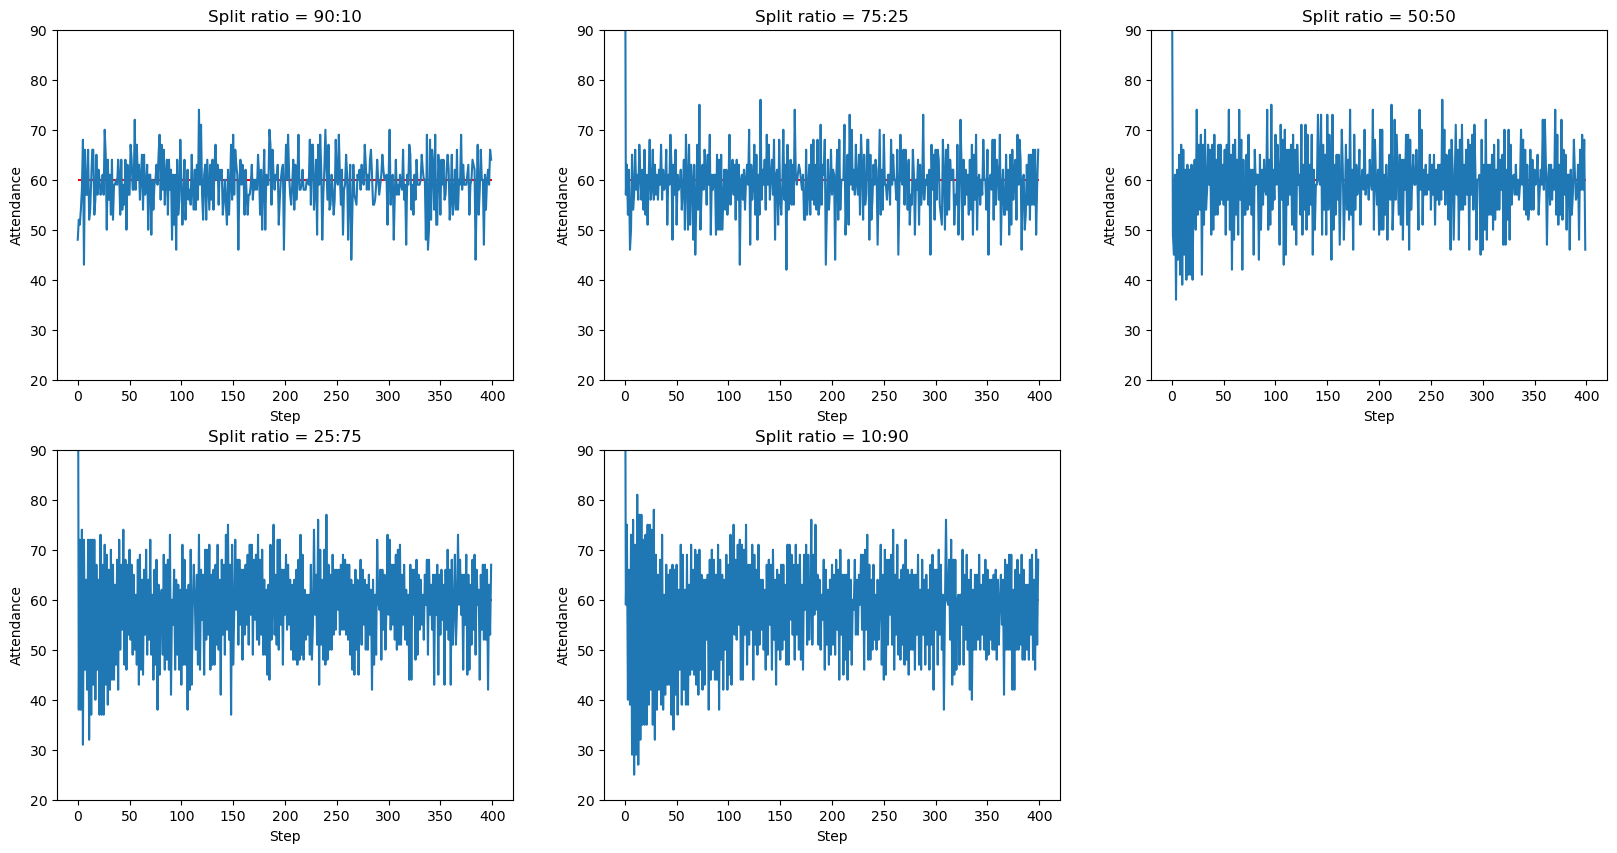

In [12]:
plt.figure(figsize=(20, 10))
idx = 1
for name, model in models.items():
    plt.subplot(2, 3, idx)
    df = model.datacollector.get_model_vars_dataframe()
    plt.plot(df["Customers"], label=name)
    plt.ylim([20, 90])
    plt.title("Split ratio = " + name)
    plt.hlines(n, 0, 400, "r")
    idx = idx + 1
    plt.xlabel("Step")
    plt.ylabel("Attendance")
plt.show()
# plt.savefig('Heterogeneity.png',dpi = 300)


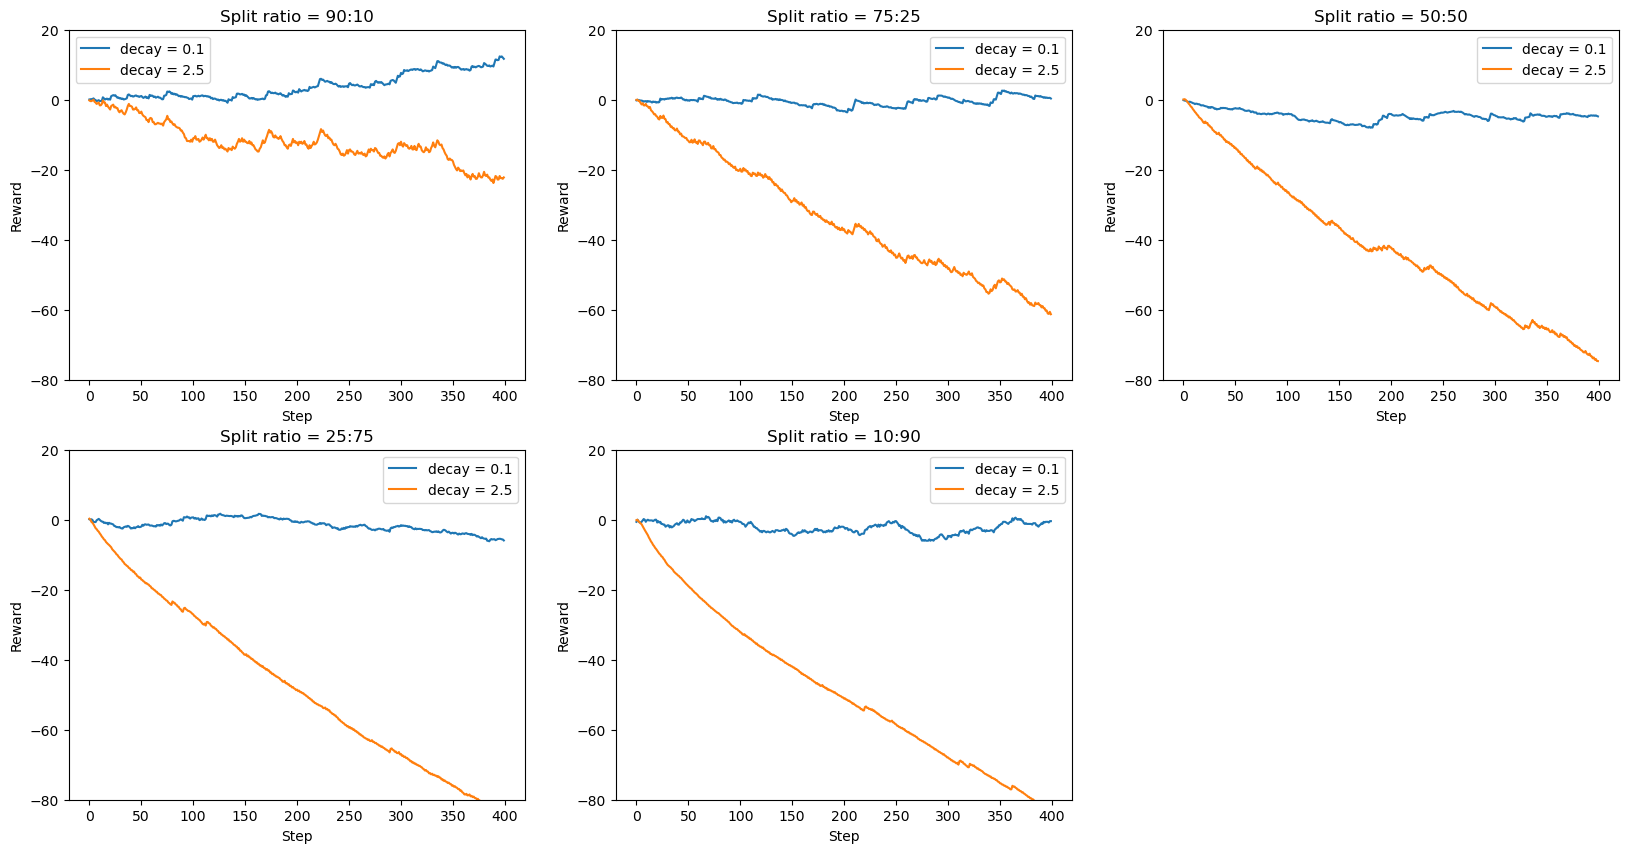

In [13]:
plt.figure(figsize=(20, 10))
idx = 1
for name, model in models.items():
    plt.subplot(2, 3, idx)
    df = model.datacollector.get_agent_vars_dataframe()
    plt.plot(
        df[df["Decay"] == 0.1]["Utility"].groupby("Step").mean(), label="decay = 0.1"
    )
    plt.plot(
        df[df["Decay"] == 2.5]["Utility"].groupby("Step").mean(), label="decay = 2.5"
    )
    plt.legend()
    # plt.plot(df['Customers'],label = name)
    plt.ylim([-80, 20])
    plt.title("Split ratio = " + name)
    idx += 1
    plt.ylabel("Reward")
    plt.xlabel("Step")
plt.show()
# plt.savefig('Heterogeneity.reward.png',dpi = 300)


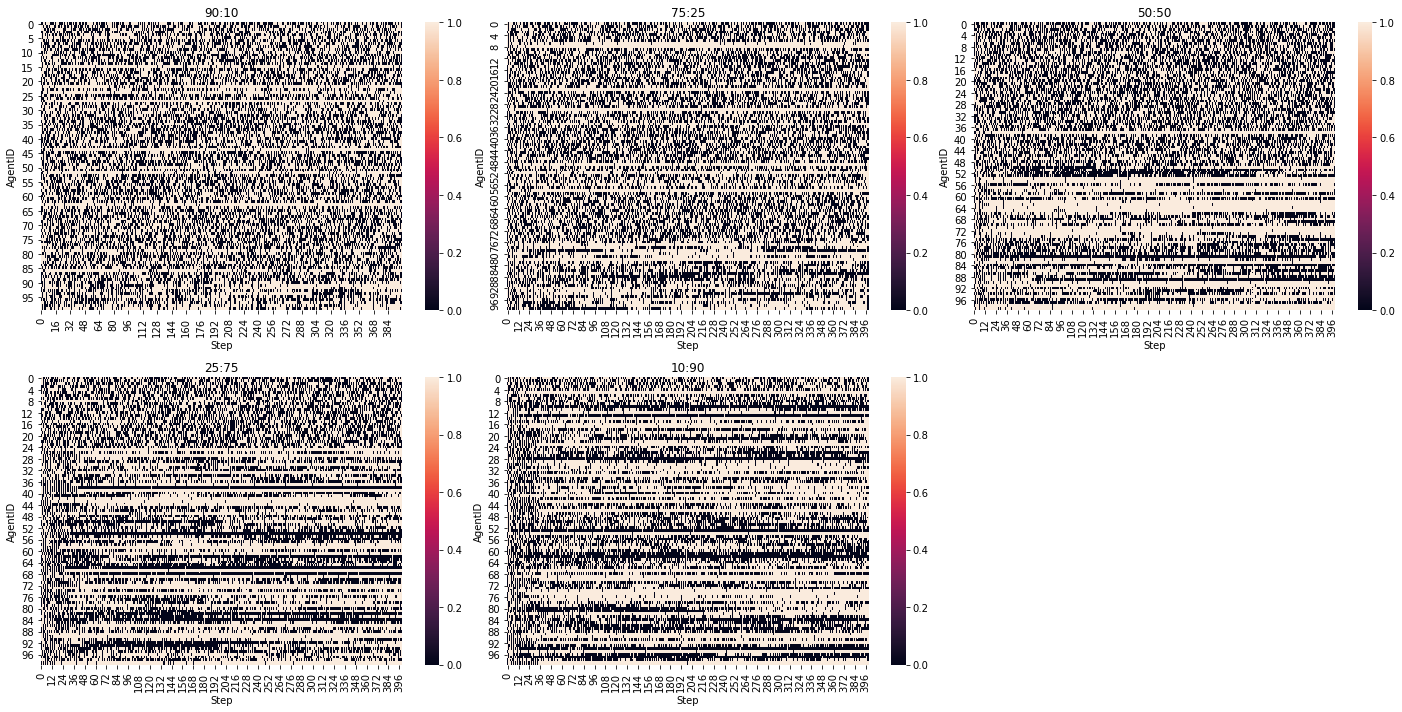

In [21]:
import seaborn as sns

plt.figure(figsize=(20, 10))
idx = 1
for name, model in models.items():
    plt.subplot(2, 3, idx)
    df = model.datacollector.get_agent_vars_dataframe()
    df.reset_index(inplace=True)
    sns.heatmap(df.pivot(index="AgentID", columns="Step", values="Attendance"))
    plt.tight_layout()
    plt.title(name)
    idx += 1
plt.savefig("Heterogeneity.heatmap.png", dpi=300)


In [15]:
n = 60
trials = 400
rep = 20

decays = [0.1, 1, 2.5, 5]
models = [
    ElFarolBarIBLT(N=100, crowdthreshold=n, decay={d: 1})
    for d in decays
    for i in range(rep)
]
len(models)


80

In [16]:
from tqdm import tqdm

n = 60
trials = 400
decays = {
    "90:10": {0.1: 0.9, 2.5: 0.1},
    "75:25": {0.1: 0.75, 2.5: 0.25},
    "50:50": {0.1: 0.5, 2.5: 0.5},
    "25:75": {0.1: 0.25, 2.5: 0.75},
    "10:90": {0.1: 0.1, 2.5: 0.9},
}
models = [
    ElFarolBarIBLT(N=100, crowdthreshold=n, decay=d)
    for name, d in decays.items()
    for i in range(rep)
]

for model in tqdm(models):
    for i in range(trials):
        model.step()


100%|██████████| 100/100 [06:54<00:00,  4.14s/it]


In [17]:
stds = []
for model in models:
    df = model.datacollector.get_model_vars_dataframe()
    df.reset_index(inplace=True)
    stds.append(df[df["index"] > 200]["Customers"].std())
print(decays.keys())
print(np.array(stds).reshape(5, 20).mean(axis=1))
print(np.array(stds).reshape(5, 20).std(axis=1))


dict_keys(['90:10', '75:25', '50:50', '25:75', '10:90'])
[5.18835466 5.99701379 7.43609386 8.6037327  9.7364356 ]
[0.19344848 0.30296816 0.39049052 0.43847742 0.62517613]
